# Title:

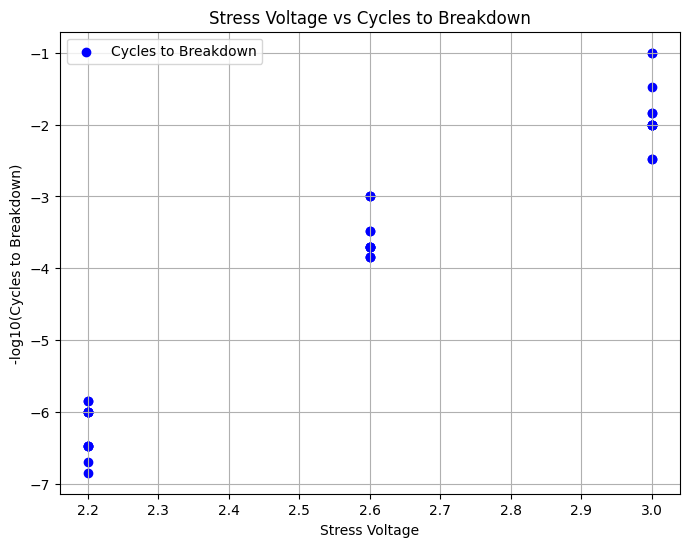

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(0)

file_path = "../Data/Cbd vs Stress Volatge data_85C.xlsx"
def read_excel_data(file_path):
    data = pd.read_excel(file_path, header=None)
    return data.iloc[0, 1:].to_numpy(), data.iloc[1, 1:].to_numpy()

try:
    x, y = read_excel_data(file_path)
    y, X = -np.log10(y.astype(float)), x.astype(float)
    # print("Stress Voltage (x):", x)
    # print("log(Cycles to Breakdown) (y):", y)
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.scatter(X, y, marker='o', color='b', label="Cycles to Breakdown")
    plt.xlabel("Stress Voltage")
    plt.ylabel("-log10(Cycles to Breakdown)")
    plt.title("Stress Voltage vs Cycles to Breakdown")
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print("Error:", e)

# Heteroskedastic Linear Regression

In **heteroskedastic linear regression**, the regression model is still the same as a standard linear regression, but the key difference is that the errors (residuals) are not assumed to have constant variance. Here's how the model is expressed, along with the key equations for heteroskedasticity.

## 1. Linear Regression Model with Heteroskedasticity

The typical **linear regression equation** is:

$y_i = \beta_0 + \beta_1 x_i + \epsilon_i$

Where:
- \(y_i\) is the dependent variable for observation \(i\).
- \(x_i\) is the independent variable for observation \(i\).
- \(\beta_0\) and \(\beta_1\) are the model coefficients.
- \(\epsilon_i\) is the error term for observation \(i\).

In heteroskedasticity, the variance of the errors \(\epsilon_i\) is not constant, i.e.,

\[
\text{Var}(\epsilon_i) = \sigma_i^2 \neq \sigma^2
\]

This implies that the variance of the errors depends on the values of the independent variables (or other factors).

## 2. Error Structure with Heteroskedasticity

The error term can be expressed as:

\[
\epsilon_i = u_i \cdot \sigma_i
\]

Where:
- \(u_i\) is the homoskedastic error term (typically assumed to have constant variance, i.e., \(u_i \sim N(0, 1)\)).
- \(\sigma_i\) is the standard deviation of the error for observation \(i\), which may vary with \(x_i\).

Thus, the errors are heteroskedastic if \(\sigma_i\) depends on \(x_i\).

## 3. Variance-Covariance Matrix for Heteroskedasticity

In ordinary least squares (OLS), we typically assume that the error terms have constant variance (\(\sigma^2\)) and are uncorrelated. However, when heteroskedasticity is present, the variance-covariance matrix of the errors becomes diagonal but with varying entries:

\[
\mathbf{V}(\hat{\boldsymbol{\epsilon}}) = \text{diag}(\sigma_1^2, \sigma_2^2, \dots, \sigma_n^2)
\]

Where:
- \(\mathbf{V}(\hat{\boldsymbol{\epsilon}})\) is the variance-covariance matrix of the residuals.
- \(\sigma_i^2\) is the error variance for observation \(i\).

## 4. Generalized Least Squares (GLS) for Heteroskedasticity

When heteroskedasticity is present, one possible solution is to use **Generalized Least Squares (GLS)**, which adjusts for varying error variances. GLS modifies the standard OLS estimation procedure by weighting each observation by the inverse of its error variance. The GLS estimator is:

\[
\hat{\boldsymbol{\beta}}_{GLS} = (\mathbf{X}^\top \mathbf{W}^{-1} \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{W}^{-1} \mathbf{y}
\]

Where:
- \(\mathbf{X}\) is the matrix of explanatory variables (including a column of ones for the intercept).
- \(\mathbf{y}\) is the vector of observations.
- \(\mathbf{W}\) is the diagonal matrix of the error variances \(\sigma_i^2\), i.e., \(\mathbf{W} = \text{diag}(\sigma_1^2, \sigma_2^2, \dots, \sigma_n^2)\).

Alternatively, if \(\sigma_i^2\) is not known, robust standard errors can be used to provide consistent estimates of the variance-covariance matrix, even when heteroskedasticity is present.

## 5. Robust Standard Errors

If GLS cannot be applied directly or is computationally infeasible, **robust standard errors** (also called White standard errors) can be used to correct for heteroskedasticity. The robust variance estimator is given by:

\[
\hat{\mathbf{V}}(\hat{\boldsymbol{\beta}}) = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \hat{\mathbf{\Omega}} \mathbf{X} (\mathbf{X}^\top \mathbf{X})^{-1}
\]

Where:
- \(\hat{\mathbf{\Omega}}\) is the diagonal matrix of squared residuals from the regression (\(\hat{\epsilon}_i^2\)).

## Summary

- In **heteroskedastic regression**, the error variance (\(\sigma_i^2\)) is not constant.
- The typical linear model equation remains the same, but the variance of the residuals varies.
- The solution to heteroskedasticity often involves using **Generalized Least Squares (GLS)** or **robust standard errors**.



In [32]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.cluster import KMeans
from gp_extras.kernels import HeteroscedasticKernel

# Gaussian Process with RBF kernel and homoscedastic noise level
kernel_homo = C(1.0, (1e-2, 100)) * RBF(1, (0.1, 100.0))
gp_homoscedastic = GaussianProcessRegressor(kernel=kernel_homo, alpha=0.2)
gp_homoscedastic.fit(X[:, np.newaxis], y)
print("Homoscedastic kernel: %s" % gp_homoscedastic.kernel_)
print("Homoscedastic LML: %.3f" \
    % gp_homoscedastic.log_marginal_likelihood(gp_homoscedastic.kernel_.theta))

# Gaussian Process with RBF kernel and heteroscedastic noise level
prototypes = KMeans(n_clusters=3).fit(X[:, np.newaxis]).cluster_centers_
kernel_hetero = C(1.0, (1e-2, 100)) * RBF(
    1, (0.1, 100.0)
) + HeteroscedasticKernel.construct(
    prototypes, 1e-1, (1e-2, 100.0), gamma=1.0, gamma_bounds="fixed"
)
gp_heteroscedastic = GaussianProcessRegressor(
    kernel=kernel_hetero, alpha=0.2, optimizer="fmin_l_bfgs_b"
)
gp_heteroscedastic.fit(X[:, np.newaxis], y)
print("Heteroscedastic kernel: %s" % gp_heteroscedastic.kernel_)
print("Heteroscedastic LML: %.3f" % gp_heteroscedastic.log_marginal_likelihood(gp_heteroscedastic.kernel_.theta))

Homoscedastic kernel: 5.72**2 * RBF(length_scale=0.99)
Homoscedastic LML: -27.946
Heteroscedastic kernel: 5.72**2 * RBF(length_scale=0.991) + HeteroscedasticKernel(sigma_2=[0.01, 0.01, 0.01], gamma=1.0)
Heteroscedastic LML: -28.206


In [38]:
from scipy.linalg import inv

data = pd.DataFrame({"Stress Voltage": x, "Cycles to Breakdown": y})

y_std_at_1 = []
for j in range(10):
    x = data["Stress Voltage"].to_numpy()
    y = data["Cycles to Breakdown"].to_numpy()
    X = x
    phi_X = np.vstack((np.ones_like(X), X)).T  # Basis functions: [1, x]
    alpha = 0.01  # Prior precision, typically smaller values (0.01, 0.1, etc.)
    beta = 1 / np.var(y)  # A better initial guess for beta
    Lambda_0 = alpha * np.eye(2)  # Prior covariance
    mu_0 = np.zeros(2)  # Prior mean
    # Compute posterior of BLR
    S_N_inv = Lambda_0 + beta * phi_X.T @ phi_X
    print(type(S_N_inv))
    S_N = np.linalg.inv(S_N_inv)
    m_N = S_N @ (Lambda_0 @ mu_0 + beta * phi_X.T @ y)
    # Residuals for GP
    y_pred_blr = phi_X @ m_N  # BLR prediction
    residuals = y - y_pred_blr
    # GP for heteroscedastic noise
    epsilon = 1e-5  # Regularization term to avoid singularity

    prototypes = X[:, np.newaxis]  # Using all points as prototypes
    kernel = (
        C(1.0, (1e-4, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
        + HeteroscedasticKernel.construct(prototypes, 1.0, (1e-4, 50.0), gamma=1.0)
        + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e1))  # Add white noise

    )  # Reduced gamma

    gp = GaussianProcessRegressor(
        kernel=kernel, alpha=0, n_restarts_optimizer=100
    )
    # gp.optimizer_kwargs = {"max_iter": 5000}
    gp.fit(X[:, np.newaxis], residuals)
    # Add a new x
    x_min, x_max = 2, 3  # Get min and max of x
    n_grid_pts = 10
    x_points = np.linspace(x_min, x_max, n_grid_pts)  # Create 100 equally spaced points
    # Gen y samples
    t = 1
    cost = []
    for i in range(n_grid_pts):
        S_N = inv(S_N_inv)
        phi_X = np.vstack(
            (np.ones_like(x_points[i]), x_points[i])
        ).T  # Basis functions: [1, x]
        # cov_blr = phi_X @ S_N @ phi_X.T
        cov_blr = S_N[1,1].item()
        gp_mean, gp_std = gp.predict(
            np.array([x_points[i]]).reshape(-1, 1), return_std=True
        )
        print(cov_blr**0.5)
        print(gp_std)
        cost = np.append(cost, cov_blr**0.5 - 0.2 * gp_std)
        min_index = np.argmin(cost)
    x_min_cost = x_points[min_index]
    # # Predictions
    phi_X_ = np.vstack((np.ones_like(x_min_cost), x_min_cost)).T
    y_pred_blr_ = phi_X_ @ m_N
    gp_mean, gp_std = gp.predict(x_min_cost.reshape(-1,1), return_std=True)
    y_pred = y_pred_blr_ + gp_mean

    # # Sample y instead of just using the mean
    # phi_X = np.vstack((np.ones_like(x_min_cost), x_min_cost)).T
    # y_sample_blr = np.random.normal(loc=phi_X_ @ m_N, scale=(phi_X @ S_N @ phi_X.T)**0.5, size=(1,1))
    # y_sample_GP = np.random.normal(loc=gp_mean, scale=gp_std, size=(1,1))
    # y_pred_tmp = y_sample_blr.item() + y_sample_GP.item()

    # print(x_min_cost)
    # print(y_pred.item())
    # Add new data points
    data.loc[len(data)] = [x_min_cost, y_pred.item()]

    # # Predictions at x = 1
    phi_X_ = np.vstack((np.ones_like(1), 1)).T
    gp_mean, gp_std = gp.predict(np.array([1]).reshape(-1, 1), return_std=True)
    cov_blr = phi_X @ S_N @ phi_X.T
    # print(cov_blr[0]**0.5)
    # print(gp_std)
    # y_std_at_1 = np.append(y_std_at_1,(cov_blr[0]**0.5).item())
    y_std_at_1 = np.append(y_std_at_1, (gp_std).item())

    # Predictions
    X_ = np.linspace(1, 3, 100)
    phi_X_ = np.vstack((np.ones_like(X_), X_)).T
    y_pred_blr_ = phi_X_ @ m_N
    gp_mean, gp_std = gp.predict(X_[:, np.newaxis], return_std=True)
    y_pred = y_pred_blr_ + gp_mean

    # Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color="r", label="Data")
    plt.plot(X_, y_pred_blr_, "g--", label="Bayesian Linear Regression (BLR)")
    plt.plot(X_, y_pred, "k-", label="BLR + GP Prediction")
    plt.fill_between(
        X_,
        y_pred - 2 * gp_std,
        y_pred + 2 * gp_std,
        color="k",
        alpha=0.2,
        label="Uncertainty (±2σ)",
    )
    plt.legend(loc="best")
    plt.xlabel("Stress Voltage")
    plt.ylabel("log(C_BD)")
    plt.xlim([1, 3])
    plt.title("Bayesian Linear Regression + GP with Heteroscedastic Noise")
    # plt.savefig(
    #     "high_def_plot_uq.png", dpi=600, bbox_inches="tight", format="png"
    # )  # Change 'png' to 'pdf' or 'svg' for vector graphics
    plt.show()


<class 'numpy.ndarray'>


UFuncTypeError: Cannot cast ufunc 'inv' input from dtype('O') to dtype('float64') with casting rule 'same_kind'